In [44]:
!nvidia-smi

Thu Jan 23 15:50:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20Xm         On   | 00000000:08:00.0 Off |                    0 |
| N/A   46C    P0    56W / 235W |   5489MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20Xm         On   | 00000000:84:00.0 Off |                    0 |
| N/A   52C    P0    56W / 235W |   5489MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [45]:
#!pip install pyforest
#from pyforest import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras


df = pd.read_csv("../data/df_final_processed.csv", index_col = 0)
df.head()

from keras.preprocessing.sequence import TimeseriesGenerator

#some zeroes
#series = df.level_scaled.values
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0.01, 1))

series = sc.fit_transform(df.level.values.reshape(-1, 1))


#test_series = series [split_index:]
#series = series [:split_index]
n_features = 1
#series = series.reshape((len(series), n_features))
#test_series = test_series.reshape((len(test_series), n_features))

series.shape


n_steps = 24

padded_series = np.expand_dims(np.concatenate([series.flatten(), series.mean()*np.ones(n_steps)]), axis = -1)

target_series = np.hstack([np.roll(padded_series, -i)[:series.shape[0]] for i in range(1,n_steps+1)])
target_series.shape

(78888, 24)

In [ ]:
#TODOS:
#- add reg
#- add gradient clipping


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, CuDNNLSTM, LeakyReLU, Dropout, BatchNormalization
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.optimizers import Adam 


# define model
def make_model(n_input, n_features, 
               verbose = False, multi = True, use_CuDNNLSTM = True,
              loss = "mse", metrics = ["mae", "mape"],
              lr = 0.001, n_steps = n_steps):
    K.clear_session()
    LSTM_layer = LSTM if not use_CuDNNLSTM else CuDNNLSTM
    opt = Adam (lr = lr )
    
    model = Sequential()
    
    model.add(LSTM_layer(1024, input_shape=(n_input, n_features), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.5))
    
    model.add(LSTM_layer(512, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout( rate = 0.4))
    
    model.add(LSTM_layer(512, return_sequences = False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.3))
    
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.2))
    
    model.add(Dense(n_steps))
    
    model.compile(optimizer=opt, loss=loss, metrics = metrics)
    if verbose:
        model.summary()
    if multi:
        mmodel = multi_gpu_model(model, 2)
        mmodel.compile(optimizer=opt, loss=loss, metrics = metrics)
        return mmodel, model
    else: 
        
        return None, model

In [46]:
# define generator
n_input = 1*24*7
batch_size = 256
split_index = -168-1
train_generator = TimeseriesGenerator(series[:split_index], target_series[:split_index], length=n_input, batch_size=batch_size)
test_generator = TimeseriesGenerator(series[-n_input + split_index:], target_series[-n_input + split_index:], length=n_input, batch_size=8)
ttest_generator = TimeseriesGenerator(series[-n_input + split_index:], target_series[-n_input + split_index:], length=n_input, batch_size=2)

In [47]:
for it, (train, test) in enumerate(ttest_generator):
    print(train, test)
    print("######\n########")
    if it == 2:
        break

[[[0.559 ]
  [0.5905]
  [0.586 ]
  [0.5455]
  [0.478 ]
  [0.4285]
  [0.397 ]
  [0.4015]
  [0.4465]
  [0.514 ]
  [0.577 ]
  [0.6175]
  [0.6445]
  [0.64  ]
  [0.577 ]
  [0.4825]
  [0.397 ]
  [0.3025]
  [0.217 ]
  [0.181 ]
  [0.1855]
  [0.2485]
  [0.343 ]
  [0.433 ]]

 [[0.5905]
  [0.586 ]
  [0.5455]
  [0.478 ]
  [0.4285]
  [0.397 ]
  [0.4015]
  [0.4465]
  [0.514 ]
  [0.577 ]
  [0.6175]
  [0.6445]
  [0.64  ]
  [0.577 ]
  [0.4825]
  [0.397 ]
  [0.3025]
  [0.217 ]
  [0.181 ]
  [0.1855]
  [0.2485]
  [0.343 ]
  [0.433 ]
  [0.5005]]] [[0.541  0.55   0.5185 0.442  0.3655 0.3025 0.28   0.298  0.3655 0.442
  0.514  0.5545 0.5725 0.55   0.478  0.3835 0.2935 0.2125 0.154  0.127
  0.1585 0.2215 0.298  0.37  ]
 [0.55   0.5185 0.442  0.3655 0.3025 0.28   0.298  0.3655 0.442  0.514
  0.5545 0.5725 0.55   0.478  0.3835 0.2935 0.2125 0.154  0.127  0.1585
  0.2215 0.298  0.37   0.433 ]]
######
########
[[[0.586 ]
  [0.5455]
  [0.478 ]
  [0.4285]
  [0.397 ]
  [0.4015]
  [0.4465]
  [0.514 ]
  [0.577 ]
  [0.

In [124]:
import wandb
wandb.login()


from wandb.keras import WandbCallback as wb

wandb.init(project = "venice_is_drowing", name = "lstm_multi_output_test_24h")
cfg = wandb.config
n_input = 1*24
batch_size = 512
cfg.gen_batch_size = batch_size
cfg.n_features = n_features
cfg.n_input = n_input
cfg.epochs = 150

True

In [157]:
# define generator
split_index = -168-1
train_generator = TimeseriesGenerator(series[:split_index], target_series[:split_index], length=n_input, batch_size=batch_size)
train_list = []
test_list = []
for train,test in train_generator:
    train_list.append(train)
    test_list.append(test)
train_input = np.concatenate(train_list, axis = 0)
train_targets = np.concatenate(test_list, axis = 0)

ttest_generator = TimeseriesGenerator(series[-n_input + split_index:], target_series[-n_input + split_index:], length=n_input, batch_size=len(target_series[-n_input + split_index:]), shuffle=False) #a whole batch size for faster splitting after the padding zone

train_test, test_test = ttest_generator[0]

train_test.shape, test_test.shape

val_train, val_test = train_test[:-20],test_test[:-20] #@-20 index starts the paddings due to h24 preds

In [159]:
mmodel, model = make_model(n_input, n_features,  n_steps = 24, lr = 0.001, 
                           multi = True, use_CuDNNLSTM = True, verbose = True,
                           loss = "mse", metrics = ["mae", "mape"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 24, 1024)          4206592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 1024)          4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 1024)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 1024)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 24, 512)           3149824   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 512)           2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 512)           0         
__________

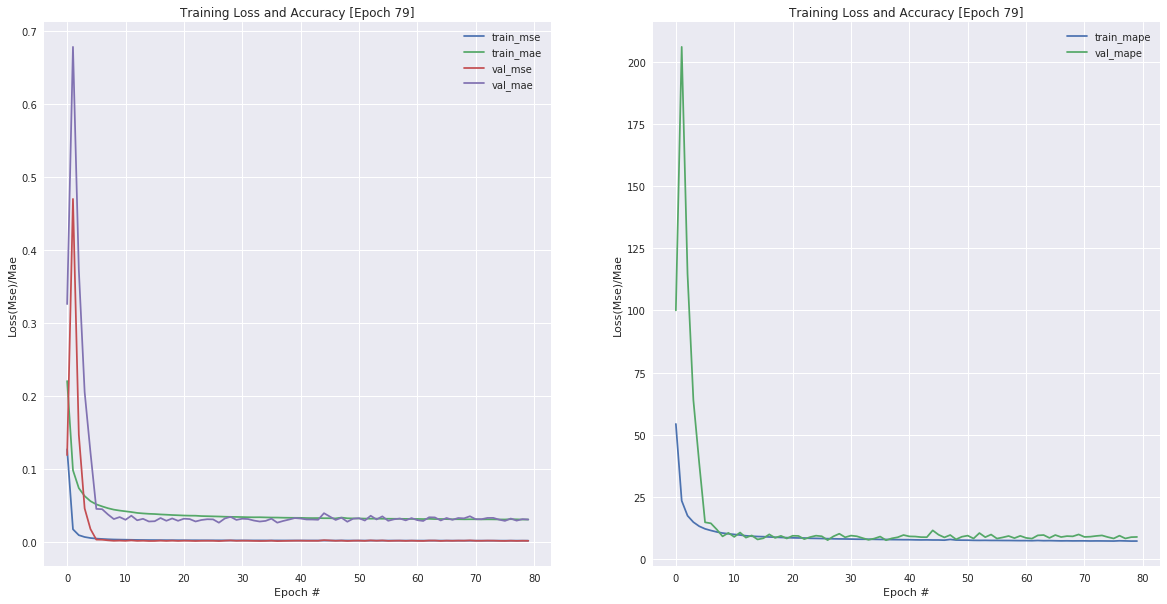

Epoch 81/150
78695/78695 [==============================] - 39s 496us/step - loss: 0.0017 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 7.3551 - val_loss: 0.0017 - val_mean_absolute_error: 0.0327 - val_mean_absolute_percentage_error: 9.3395
Epoch 82/150
78695/78695 [==============================] - 40s 507us/step - loss: 0.0017 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 7.3417 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307 - val_mean_absolute_percentage_error: 8.9613
Epoch 83/150
78695/78695 [==============================] - 40s 511us/step - loss: 0.0017 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 7.3496 - val_loss: 0.0017 - val_mean_absolute_error: 0.0324 - val_mean_absolute_percentage_error: 9.7004
Epoch 84/150
78695/78695 [==============================] - 41s 520us/step - loss: 0.0017 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 7.3387 - val_loss: 0.0019 - val_mean_absolute_error: 0.0349 - val_mea

In [160]:
from keras.callbacks import EarlyStopping
from myutils import TrainingPlot

plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 1)
# fit model
history = mmodel.fit(train_input, train_targets,
    epochs=cfg.epochs,
    batch_size = batch_size,
    
    verbose=1, 
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (val_train, val_test),
    
    callbacks=[plot_losses, 
              es, 
              wb(log_gradients=False, log_weights=False)
              ]
)

In [161]:
model.evaluate(val_train, val_test)

149/149 [==============================] - 1s 4ms/step


[0.001137318982642719, 0.026385619386330546, 7.719998007652744]

In [142]:
from keras.callbacks import EarlyStopping
from myutils import TrainingPlot

plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 1)
# fit model
history = mmodel.fit_generator(
    train_generator,  
    epochs=cfg.epochs,
    steps_per_epoch=10,
    verbose=1, 
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (val_train, val_test),
    
    callbacks=[plot_losses, 
              # es, 
              # wb(log_gradients=False, log_weights=False)
              ]
)

Epoch 1/150
10/10 [==============================] - 5s 491ms/step - loss: 0.9924 - mean_absolute_error: 0.7848 - mean_absolute_percentage_error: 183.1849 - val_loss: 2.6954 - val_mean_absolute_error: 1.3259 - val_mean_absolute_percentage_error: 393.3767
Epoch 2/150
10/10 [==============================] - 1s 117ms/step - loss: 0.5325 - mean_absolute_error: 0.5742 - mean_absolute_percentage_error: 138.0820 - val_loss: 2.3434 - val_mean_absolute_error: 1.1926 - val_mean_absolute_percentage_error: 353.7223
Epoch 3/150
10/10 [==============================] - 1s 117ms/step - loss: 0.2812 - mean_absolute_error: 0.4171 - mean_absolute_percentage_error: 112.8265 - val_loss: 1.2455 - val_mean_absolute_error: 0.8269 - val_mean_absolute_percentage_error: 246.1078
Epoch 4/150
10/10 [==============================] - 1s 117ms/step - loss: 0.1910 - mean_absolute_error: 0.3438 - mean_absolute_percentage_error: 81.5971 - val_loss: 0.8951 - val_mean_absolute_error: 0.7394 - val_mean_absolute_percenta

KeyboardInterrupt: 

In [ ]:
#model.save("lstm_1_step_ahead_y_10_18.h5") #more compat along win loading

In [ ]:
init_test_arr = series[-n_input+split_index:split_index]
test_features = np.squeeze(init_test_arr, axis = -1).tolist()
test_features.append(3)
np.atleast_3d(test_features[-n_input:])

In [ ]:
pred = model.predict(np.expand_dims(init_test_arr, axis = 0))
pred[0][0]

In [ ]:
def iterate_prediction(input_seq = series[-n_input+split_index:split_index], pred_len = 168):
    init_test_arr = np.expand_dims(input_seq, axis = 0)
    preds = []
    for i in range(pred_len):
        test_features = np.squeeze(np.squeeze(init_test_arr, axis = -1), axis = 0).tolist()
        pred = model.predict(init_test_arr)[0][0]
        preds.append(pred)
        test_features.append(pred)
        init_test_arr = np.atleast_3d(test_features[-n_input:])

    return np.array(preds)

preds = iterate_prediction()



In [ ]:
real_preds = model.predict_generator(test_generator).flatten()
real_data = series[split_index:].flatten()

def plot_preds(real_preds, real_data, preds):
    plt.plot(real_preds, label = "real data preds")
    plt.plot(preds, label = "iterated preds")
    plt.plot(real_data, label = "real data")
    plt.legend()
    plt.show()

plot_preds(real_preds, real_data, preds)

In [ ]:
real_data[0:10],preds[0:10]

In [ ]:
def calc_mape(real, pred):
    return (100*np.abs(real-pred)/real/real.shape[0]).sum()
print(calc_mape(real_data, real_preds)) #mape on real-data preds
print(calc_mape(real_data, preds)) #mape on iterated preds
print(calc_mape(real_data[0:1], preds[0:1]))

In [ ]:
pred_generator = TimeseriesGenerator(series[-n_input + split_index:], series[-n_input + split_index:], length=n_input, batch_size=1)
mmodel.predict_generator(test_generator, steps=1)[0]

In [ ]:
test_series = series[split_index:]
test_series[0]

In [ ]:
mape = (test_series[0]-mmodel.predict_generator(test_generator, steps=1)[0])/test_series[0]
mape

In [ ]:
#plt.plot(history1.history["mean_absolute_error"], label = "mae")
#plt.plot(history1.history["mean_absolute_percentage_error"], label = "mape")
#plt.plot(history1.history["val_mean_absolute_error"], label = "val_mae")
plt.plot(history1.history["val_mean_absolute_percentage_error"], label = "val_mse")
#plt.ylim((0,1))
plt.legend()
plt.plot()

In [ ]:
plt.plot(test_series[1:])
plt.plot(model.predict_generator(test_generator)[:-1])

In [ ]:
for x, y in test_generator:
  print(x)
  print("#")
  print(y)
  break

In [ ]:
model.evaluate_generator(test_generator)